##### **Импорт библиотек**



In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

##### **Спектральная мощность в Дб и частоты функция**


In [ ]:
def PSD(row, df):
    # Применяем быстрое преобразование Фурье к данным
    PSD_row = np.fft.fft(row)
    
    # Нормируем результат FFT, деля на длину строки
    PSD_row = PSD_row / len(PSD_row)
    
    # Оставляем только первую половину спектра
    PSD_row = PSD_row[:round(len(PSD_row)/2)]
    
    # Добавляемзначение для предотвращения логарифмических ошибок
    PSD_row += 0.00001
    
    # Вычисляем мощность спектра 
    PSD_row = pow(np.abs(PSD_row), 2)

    # Создаем массив частот половины спектра
    f = np.linspace(0, df // 2, len(PSD_row))
    
    # Возвращаем массив частот и мощность спектра в Дб
    return f, 10 * np.log10(PSD_row)

##### **PSD для "дыхания" синусоиды и х заданного численным методом от дыхания**

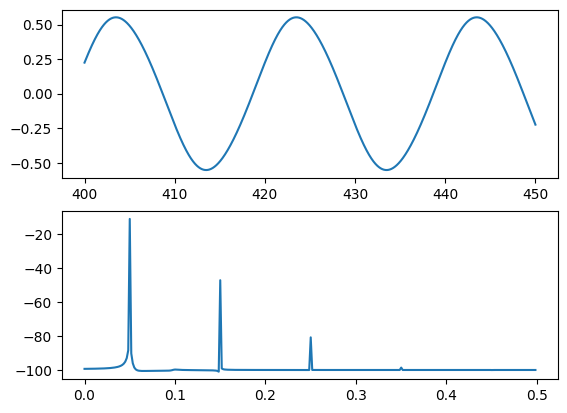

In [ ]:
df = 250  # Частота дискретизации (Гц)
dt = 1 / df  # Период дискретизации (с)
L_s = 1000  # Длительность сигнала (с)
L = L_s*df  # Общее количество отсчетов

# Создаем массив единиц длины L
x = np.ones(L)

# Создаем временной массив
t = np.linspace(0, L_s, L)  # временные точки?

Eps = 2 
Tau = round(3.6*df) 
Alpha = -1.65 
Betta = 1

# Синусоида для дыхания
Resp = np.sin(2*math.pi*0.05*t)  # Частота 0.05 Гц

# Цикл для расчета х
for i in range(Tau,L):
    x[i] = dt*(-x[i-1] + Alpha*np.tanh(Betta*x[i-Tau])+Resp[i])/Eps + x[i-1]

x = x[400*df:]  # Убираем первые 400 х
t = t[400*df:]  # Убираем первые 400 t
Resp = Resp[400*df:]  # Убираем первые 400 resp

# Вычисляем ПСД для x и частоты f
f, PSD_x = PSD(x, df)

# Строим график: 1-й подграфик - сигнал x
plt.subplot(2, 1, 1)
plt.plot(t[:50 * df], x[:50 * df])  # Первые 50 секунд сигнала
plt.title('Сигнал x')  # Заголовок графика
plt.xlabel('Время (с)')  # Подпись оси X
plt.ylabel('Амплитуда')  # Подпись оси Y

# 2-й подграфик - ПСД в децибелах
plt.subplot(2, 1, 2)
plt.plot(f[:300], PSD_x[:300])  # Первые 300 отсчетов ПСД
plt.title('ПСД сигнала x')  # Заголовок графика
plt.xlabel('Частота (Гц)')  # Подпись оси X
plt.ylabel('ПСД (дБ)')  # Подпись оси Y

# Отображаем графики
plt.tight_layout()  # Автоматическая компоновка графиков
plt.show()  # Отображение графиков

In [4]:
'''
Resp = np.sin(2*math.pi*1*t)
Phase = 2*math.pi*1*t
Phase_num = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда
plt.subplot(2,1,1)
plt.plot(t[:5*df]-400,Resp[:5*df])
plt.subplot(2,1,2)
plt.plot(t[:5*df]-400,Phase[:5*df]-min(Phase))
plt.plot(t[:5*df]-400,Phase_num[:5*df]-min(Phase_num))
plt.show()
'''

'\nResp = np.sin(2*math.pi*1*t)\nPhase = 2*math.pi*1*t\nPhase_num = np.unwrap(np.angle(scipy.signal.hilbert(Resp))) #Гильберт 1 ряда\nplt.subplot(2,1,1)\nplt.plot(t[:5*df]-400,Resp[:5*df])\nplt.subplot(2,1,2)\nplt.plot(t[:5*df]-400,Phase[:5*df]-min(Phase))\nplt.plot(t[:5*df]-400,Phase_num[:5*df]-min(Phase_num))\nplt.show()\n'

##### **Фазы и метод Гильберта**

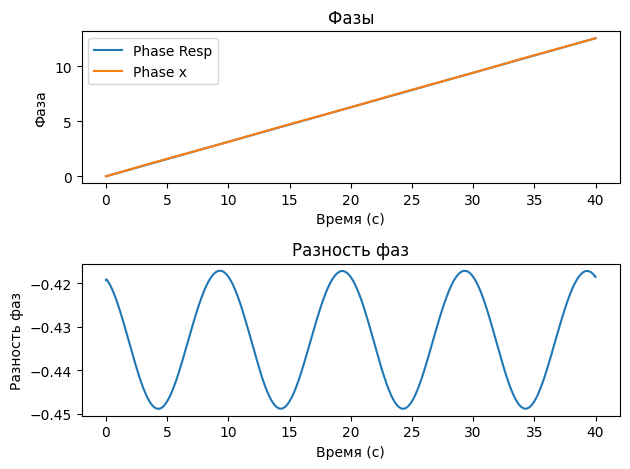

In [22]:

# Фаза с помощью преобразования Гильберта для Resp
Phase_resp = np.unwrap(np.angle(scipy.signal.hilbert(Resp)))
# Фазас помощью преобразования Гильберта для сигнала x
Phase_x = np.unwrap(np.angle(scipy.signal.hilbert(x)))

plt.subplot(2, 1, 1)
# Отображаем фазу Resp с вычитанием минимального значения 
plt.plot(t[:40*df] - 400, Phase_resp[:40*df] - min(Phase_resp), label='Phase Resp')
# Отображаем фазу сигнала x также с вычитанием минимального значения
plt.plot(t[:40*df] - 400, Phase_x[:40*df] - min(Phase_x), label='Phase x')

plt.title('Фазы')
plt.xlabel('Время (с)')
plt.ylabel('Фаза')
plt.legend()

plt.subplot(2, 1, 2)
# разность фаз между Resp и x
plt.plot(t[:40*df] - 400, Phase_resp[:40*df] - Phase_x[:40*df])

plt.title('Разность фаз')
plt.xlabel('Время (с)')
plt.ylabel('Разность фаз')

plt.tight_layout()
plt.show()

##### **Наклон с curve_fit**

In [ ]:
from scipy.optimize import curve_fit  # curve_fit нелинейный метод наименьших квадратов для подгонки функции f к данным

# функция прямой (f)
def line(x, a, b):
    return a * x + b  # Линейная функция, где a - наклон, b - пересечение с осью Y

# Используем curve_fit для подгонки функции line к данным (разности фаз)
popt, pcov = curve_fit(line, t, Phase_resp - Phase_x)  # t - независимая переменная, разность фаз - зависимая
# popt содержит оптимальные параметры a и b, pcov содержит матрицу ковариации

A = popt[0]  # Извлекаем оптимальный наклон (a) из результата подгонки
print(A)  # Выводим значение наклона на экран

3.530582135387754e-07


##### ****

In [ ]:
from scipy.optimize import curve_fit  # Импортируем функцию curve_fit для подгонки кривых

# Определяем линейную функцию для подгонки
def line(x, a, b):
    return a * x + b  # Линейная функция: y = a*x + b

# функция для синхронизации
def Synch_det(df, f_resp, gain):
    dt = 1 / df  # Период дискретизации (с)
    L_s = 1000  # Длина сигнала в секундах
    L = L_s * df  # Общее количество отсчетов

    x = np.ones(L)  # Заполняем массив x единицами
    t = np.linspace(0, L_s, L)  # Создаем временной массив t
    Eps = 2  
    Tau = round(3.6 * df) 
    Alpha = -1.65  
    Betta = 1  

    # Resp как синусоида
    Resp = np.sin(2 * math.pi * f_resp * t)

    for i in range(Tau, L):
        x[i] = dt * (-x[i-1] + Alpha * np.tanh(Betta * x[i-Tau]) + gain * Resp[i]) / Eps + x[i-1]

    # Убираем первые 400*df выборок
    x = x[400 * df:]
    t = t[400 * df:]
    Resp = Resp[400 * df:]

    # Вычисляем фазу с помощью преобразования Гильберта
    Phase_resp = np.unwrap(np.angle(scipy.signal.hilbert(Resp)))
    Phase_x = np.unwrap(np.angle(scipy.signal.hilbert(x)))

    # Вычисляем разницу фаз
    Phase_diff = Phase_resp - Phase_x

    # Подгоняем линейную функцию к разнице фаз
    popt, pcov = curve_fit(line, t, Phase_diff)  # t - независимая переменная, Phase_diff - зависимая
    A = popt[0]  # Извлекаем оптимальный наклон (a) из подгонки

    return A  # Возвращаем значение наклона

##### ****

In [ ]:
# Генерируем массивы частот и коэффициентов усиления
Resp_freq = np.linspace(0.05, 0.15, 100)  # 100 значений частот от 0.05 до 0.15
Gain_array = np.linspace(0, 0.5, 100)  # 100 значений коэффициента усиления от 0 до 0.5

# Создаем двумерный массив Map для хранения результатов
Map = np.zeros((100, 100))  

for i in range(len(Resp_freq)):
    print(i)  # Вывод текущего индекса i
    for j in range(len(Gain_array)):
        # Вызываем функцию Synch_det и записываем результат в соответствующую ячейку массива Map
        Map[len(Resp_freq) - j - 1, i] = Synch_det(df, Resp_freq[i], Gain_array[j])

# Запись результата в файл
np.savetxt('synchronization_map.csv', Map, delimiter=',')  # Сохраняем массив Map в CSV файл

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


##### ****

In [1]:
import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков

plt.figure(figsize=(10, 8))

# Отображаем массив Map как изображение (тепловую карту)
plt.imshow(abs(Map), cmap='viridis', aspect='auto')  # 'viridis' - цветовая схема, aspect='auto' для автоматического соотношения сторон

# Добавляем цветовую шкалу с меткой 'Magnitude'
plt.colorbar(label='Magnitude')

# Устанавливаем метки по оси x с округлёнными значениями частот отклика
plt.xticks(np.arange(len(Resp_freq)), np.round(Resp_freq, 2), fontsize=4.5)

# Устанавливаем метки по оси y с округлёнными значениями коэффициента усиления (обратный порядок)
plt.yticks(np.arange(len(Gain_array)), np.round(Gain_array[::-1], 1), fontsize=5)

# Добавляем заголовок к графику
plt.title('Heatmap', fontsize=16)

# Добавляем названия осей
plt.xlabel('Частота', fontsize=12)  # Название оси x
plt.ylabel('Усиление', fontsize=12)  # Название оси y

# Настраиваем автоматическое форматирование меток по оси x, поворачиваем их на 45 градусов
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()

plt.show()

NameError: name 'Map' is not defined

<Figure size 1000x800 with 0 Axes>